In [1]:
import os
import PIL
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from IPython.display import clear_output

import tensorflow.keras.layers as layers
import tensorflow.keras as keras
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [2]:
LIST_DIR = "./data/benchmark_RELEASE/dataset"
IMAGES_PATH = os.path.join(LIST_DIR, "img")
SEG_PATH = os.path.join(LIST_DIR, "pngs")

IMG_HEIGHT = 240
IMG_WIDTH = 240
BATCH_SIZE = 64
EPOCHS = 100
OUTPUT_CHANNELS = 21

In [3]:
list_files = tf.io.gfile.glob(os.path.join(LIST_DIR, "*.txt"))

def split_dataset(files):
    output = collections.defaultdict()
    for file_name in files:
        basepath = os.path.basename(file_name)[:-4]
        image_list = tf.io.gfile.GFile(file_name, 'r').read().strip("\n").split("\n")
        output[basepath] = sorted(image_list)
        
    return output

splits = split_dataset(list_files)

In [4]:
def random_crop(image, mask, H=512, W=512):
    image_dims = image.shape
    offset_h = tf.random.uniform(
        shape=(1,), maxval=image_dims[0] - H, dtype=tf.int32)[0]
    offset_w = tf.random.uniform(
        shape=(1,), maxval=image_dims[1] - W, dtype=tf.int32)[0]

    image = tf.image.crop_to_bounding_box(image,
                                          offset_height=offset_h,
                                          offset_width=offset_w,
                                          target_height=H,
                                          target_width=W)
    mask = tf.image.crop_to_bounding_box(mask,
                                         offset_height=offset_h,
                                         offset_width=offset_w,
                                         target_height=H,
                                         target_width=W)
    return image, mask

def get_image(image_path, img_height=512, img_width=512, mask = False, flip = 0):
    img = tf.io.read_file(image_path)
    
    if mask != True:
        img = tf.cast(tf.image.decode_jpeg(img, channels=3), tf.float64)
        img = tf.image.resize(images=img, size=[img_height, img_width])
        img = tf.image.random_brightness(img, max_delta=50.)
        img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
        img = tf.image.random_hue(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
        img = tf.clip_by_value(img, 0, 255)
        img = tf.case([
            (tf.greater(flip, 0), lambda: tf.image.flip_left_right(img))
        ], default=lambda: img)
        img = img[:, :, ::-1] - tf.constant([104.00698793,116.66876762,122.67891434])
    else:
        img = tf.image.decode_png(img, channels=1)
        img = tf.cast(tf.image.resize(images=img, size=[img_height, img_width]), dtype=tf.uint8)
        img = tf.case([
            (tf.greater(flip, 0), lambda: tf.image.flip_left_right(img))
        ], default=lambda: img)
        
    return img

def load_data(path):
    flip = tf.random.uniform(
        shape=[1, ], minval=0, maxval=2, dtype=tf.int32)[0]
    
    img_path = tf.strings.join(inputs=(IMAGES_PATH, "/", path, ".jpg"))
    seg_path = tf.strings.join(inputs=(SEG_PATH, "/", path, ".png"))
    
    image, mask = get_image(img_path, flip=flip), get_image(seg_path, mask=True, flip=flip)
    image, mask = random_crop(image, mask, H=IMG_HEIGHT, W=IMG_WIDTH)
    
    return image, mask

train = tf.data.Dataset.from_tensor_slices((splits["train"]))
train = train.shuffle(buffer_size=128)
train = train.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val = tf.data.Dataset.from_tensor_slices((splits["val"]))
val = val.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_dataset = val.batch(BATCH_SIZE)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

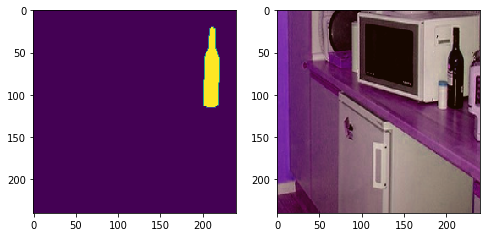

In [5]:
for i in train_dataset.take(1):
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(tf.keras.preprocessing.image.array_to_img(i[1][0]))
    ax[1].imshow(tf.keras.preprocessing.image.array_to_img(i[0][0]))

In [6]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), dilation=1):
    # A block that has a conv layer at shortcut.
    filter1, filter2, filter3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    strides = (1, 1) if dilation > 1 else strides

    x = layers.Conv2D(filter1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filter2, kernel_size, padding='same', name=conv_name_base + '2b', dilation_rate=dilation)(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filter3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def identity_block(input_tensor, kernel_size, filters, stage, block, dilation=1):
    # The identity block is the block that has no conv layer at shortcut.
    filter1, filter2, filter3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filter1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a', momentum=0.95, epsilon=1e-5)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filter2, kernel_size, padding='same', name=conv_name_base + '2b', dilation_rate=dilation)(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b', momentum=0.95, epsilon=1e-5)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c', momentum=0.95, epsilon=1e-5)(x)
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)

    return x


def resnet50(img_input):
    x = layers.ZeroPadding2D((3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1', momentum=0.95, epsilon=1e-5)(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D((1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    f1 = x

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = x

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', dilation=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', dilation=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', dilation=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', dilation=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', dilation=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', dilation=2)
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', dilation=4)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', dilation=4)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', dilation=4)
    f5 = x

    return [f1, f2, f3, f4, f5]

In [7]:
class Interp(layers.Layer):
    def __init__(self, new_size, **kwargs):
        self.new_size = new_size
        super(Interp, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Interp, self).build(input_shape)

    def call(self, inputs, **kwargs):
        new_height, new_width, _ = self.new_size
        try:
            resized = tf.image.resize(inputs, [new_height, new_width])
        except AttributeError:
            resized = tf.image.resize(inputs, [new_height, new_width],
                                             align_corners=True)
        return resized

    def compute_output_shape(self, input_shape):
        return tuple([None,
                      self.new_size[0],
                      self.new_size[1],
                      input_shape[3]])

    def get_config(self):
        config = super(Interp, self).get_config()
        config['new_size'] = self.new_size
        return config

def interp_block(prev_layer, level, feature_map_shape, input_shape):
    kernel_strides_map = {1: 30,
                        2: 15,
                        3: 10,
                        6: 5}

    names = [
      "conv5_3_pool" + str(level) + "_conv",
      "conv5_3_pool" + str(level) + "_conv_bn"
    ]

    kernel = (kernel_strides_map[level], kernel_strides_map[level])
    strides = (kernel_strides_map[level], kernel_strides_map[level])

    prev_layer = layers.AveragePooling2D(kernel, strides=strides)(prev_layer)
    prev_layer = layers.Conv2D(512, (1, 1), strides=(1, 1), name=names[0], use_bias=False)(prev_layer)
    prev_layer = layers.BatchNormalization(name=names[1])(prev_layer)
    prev_layer = layers.Activation('relu')(prev_layer)
    prev_layer = Interp(feature_map_shape)(prev_layer)

    return prev_layer

def build_pyramid_pooling_module(res, input_shape):
    feature_map_size = tuple(int(ceil(input_dim / 8.0))
                             for input_dim in input_shape)

    interp_block1 = interp_block(res, 1, feature_map_size, input_shape)
    interp_block2 = interp_block(res, 2, feature_map_size, input_shape)
    interp_block3 = interp_block(res, 3, feature_map_size, input_shape)
    interp_block6 = interp_block(res, 6, feature_map_size, input_shape)

    res = layers.Concatenate()([res,
                        interp_block6,
                        interp_block3,
                        interp_block2,
                        interp_block1])

    return res
  

def pspnet(input_shape, num_classes):
    img_input = keras.layers.Input(input_shape)

    [f1, f2, f3, f4, f5] = resnet50(img_input)

    psp = build_pyramid_pooling_module(f5, input_shape)

    x = layers.Conv2D(512, 3, strides=1, padding='same')(psp)
    x = layers.BatchNormalization(momentum=0.95, epsilon=1e-5)(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Conv2D(num_classes, 1, strides=1)(x)

    outputs = Interp(input_shape)(x)

    return keras.Model(img_input, outputs)

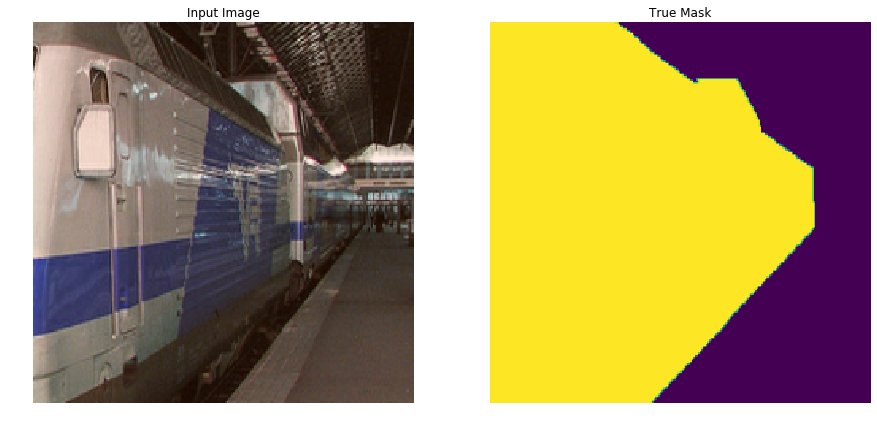

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [9]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

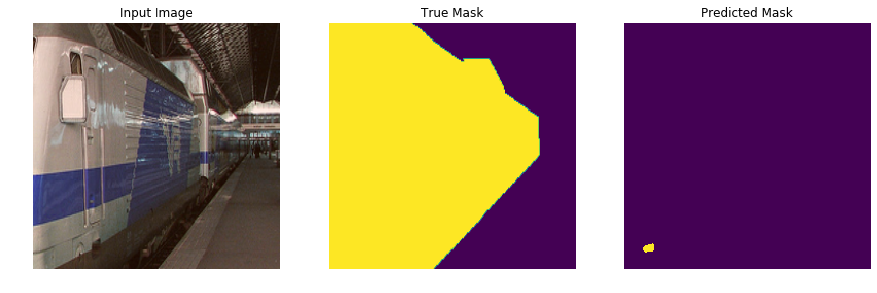


Sample Prediction after epoch 1

  1/132 [..............................] - ETA: 5:39:30

KeyboardInterrupt: 

In [10]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
model = pspnet((IMG_HEIGHT, IMG_WIDTH, 3), OUTPUT_CHANNELS)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss=loss, metrics=['accuracy'])
    
tb = TensorBoard(log_dir='logs', write_graph=True, update_freq='batch')
mc = ModelCheckpoint(mode='min', filepath='top_weights.h5',
                     monitor='val_loss',
                     save_best_only='True',
                     save_weights_only='True', verbose=1)

ds = DisplayCallback()

callbacks = [ds]

model_history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        steps_per_epoch=len(splits["train"]) // BATCH_SIZE,
                        validation_data=val_dataset,
                        validation_steps=len(splits["val"]) // BATCH_SIZE,
                        callbacks=callbacks)